<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbARIMAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 38.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip3 install pmdarima

     |████████████████████████████████| 1.4 MB 36.0 MB/s 


In [4]:
import statsmodels
print (statsmodels.__version__)
!python --version

0.13.1
Python 3.7.12


In [52]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from math import sqrt

In [19]:
filename = '/content/drive/Shared drives/CMPE295B/JoinedPGEBulbData/2021-09-13_22_2021-11-04_22_hourly.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True).drop(['Unnamed: 0'], axis=1, inplace=False)
bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [20]:
bulb_data.head()

,timestamp,brightness,kelvin,kWH,cost,usage,percent_usage_by_bulb,cost_per_bulb
0,2021-09-13 22:00:00,1.000000,2700.0,0.0085,0.13,0.50,1.700000,0.002210
1,2021-09-13 23:00:00,1.000000,2700.0,0.0085,0.08,0.29,2.931034,0.002345
2,2021-09-14 00:00:00,1.000000,2700.0,0.0085,0.08,0.28,3.035714,0.002429
3,2021-09-14 01:00:00,1.000000,2700.0,0.0085,0.08,0.28,3.035714,0.002429
4,2021-09-14 02:00:00,0.983333,2655.0,0.0085,0.05,0.25,3.400000,0.001700


### Visualize time series data

In [21]:
bulb_data['cost_per_bulb_2'] = bulb_data['cost_per_bulb'] * 2
bulb_data['cost_per_bulb_2'].max()

0.005666666666666668

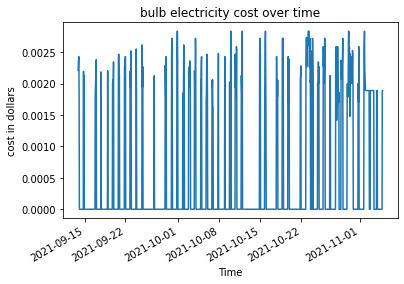

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(bulb_data['timestamp'], bulb_data['cost_per_bulb'])
plt.gcf().autofmt_xdate()
plt.title('bulb electricity cost over time')
plt.ylabel('cost in dollars')
plt.xlabel('Time')
plt.show()

In [23]:
def drop_hours_from_timestamp(bulb_data):
  bulb_data['timestamp'] = bulb_data['timestamp'].dt.strftime('%Y-%m-%d')
  bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

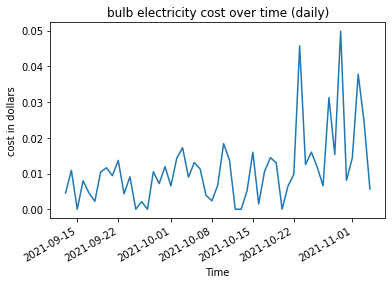

,timestamp,cost_per_bulb
0,2021-09-13,0.004555
1,2021-09-14,0.010876
2,2021-09-15,0.000000
3,2021-09-16,0.007958
4,2021-09-17,0.004566


In [24]:
bulb_data_daily = bulb_data.copy()
drop_hours_from_timestamp(bulb_data_daily)

bulb_data_daily_aggd = bulb_data_daily.groupby(['timestamp']).agg({
  'cost_per_bulb': 'sum'
})
bulb_data_daily_aggd.reset_index(inplace=True)

plt.plot(bulb_data_daily_aggd['timestamp'], bulb_data_daily_aggd['cost_per_bulb'])
plt.gcf().autofmt_xdate()
plt.title('bulb electricity cost over time (daily)')
plt.ylabel('cost in dollars')
plt.xlabel('Time')
plt.show()

bulb_data_daily_aggd.head()

### View autocorrelation plot
- How correlated are current timesteps to previous ones

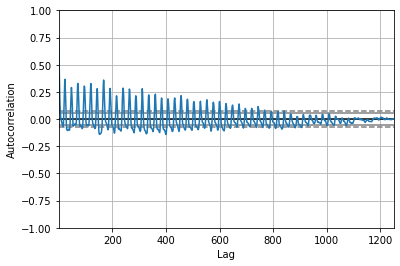

In [25]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(bulb_data[['cost_per_bulb']])
plt.show()

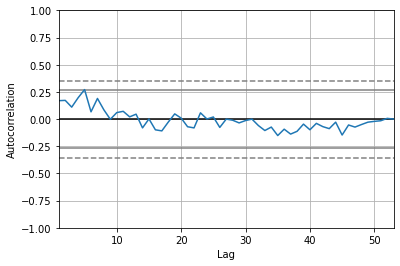

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(bulb_data_daily_aggd[['cost_per_bulb']])
plt.show()

- Looks like there is not a lot of correlation between timesteps?
- Confidence interval = 95% so focus on correlations within this interval as they are likely not statistical flukes


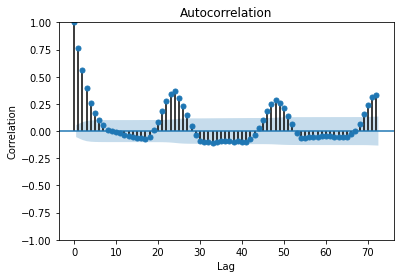

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bulb_data[['cost_per_bulb']], lags=72)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

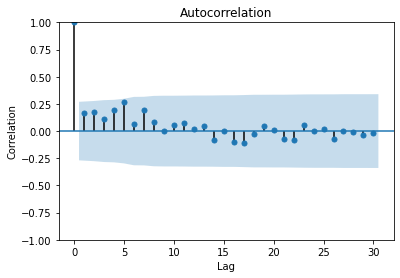

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bulb_data_daily_aggd[['cost_per_bulb']], lags=30)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

- Data does not visually look stationary and may even exhibit seasonality
- Augmented Dickey-Fuller Test? - determines a differencing order is needed

### View partial autocorrelation
- Removes indirect relationships between lags

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


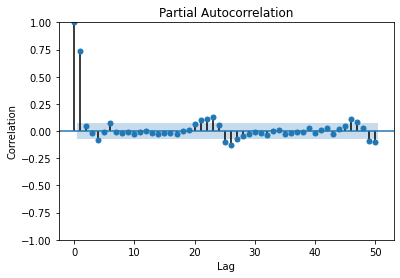

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(bulb_data[['cost_per_bulb']], lags=50)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### Summary
- ACF correlation should be strong for the first k lags then taper off
- PACF should have *no* correlation after k
- Want data to be stationary - remove any trends beforehand analysis
- Ex correlation plots: https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm

In [32]:
def split_train_test(bulb_data, split):
  arima_df = bulb_data[['timestamp', 'cost_per_bulb']]
  arima_df.set_index('timestamp', drop=True, inplace=True)
  values = arima_df.values
  size = int(len(values) * split)
  train = values[:size]
  test = values[size:]
  return (train, test)

In [49]:
train, test = split_train_test(bulb_data[['timestamp', 'cost_per_bulb']], 0.8)
print (len(train), len(test))

999 250


In [62]:
average_predictions = [np.mean(test) for i in range(len(test))]
previous_predictions = [test[0]] + [test[i-1] for i in range(1, len(test))]
baseline_rmse = sqrt(mean_squared_error(test, previous_predictions))
baseline_rmse

0.000631303848447963

In [ ]:
from pmdarima.arima import ADFTest
ADFTest(alpha = 0.05).should_diff(train)

(0.01, False)

In [37]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

def fit_model(train, order=(10, 1, 0)):
  model = ARIMA(train, order=order)
  model_fit = model.fit()

  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  residuals.plot(kind='kde')

  return model_fit, residuals

### Model parameters

- p = number of lagged observations to use - how many previous time steps will affect the current one?

- d = differencing factor, how many previous timesteps to subtract from the current one to make the series stationary? most non-seasonal models will not go higher than 2 in practice to avoid over-differencing

- q = moving average window - adjusts averages based on current errors to make the model better, assumes there is some autocorrelation in the residuals

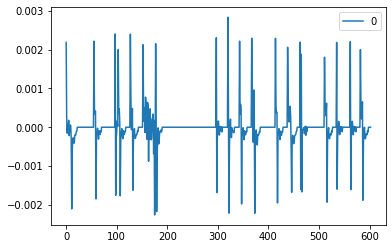

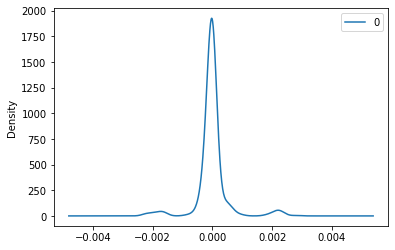

In [ ]:
model_fit, residuals = fit_model(train)

### Residuals from the model don't have significant autocorrelations - may not need a moving average window

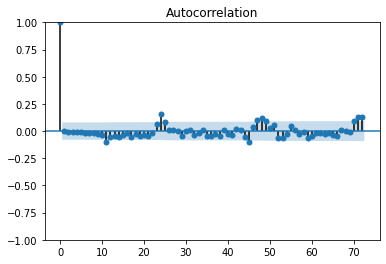

In [ ]:
plot_acf(residuals, lags=72)
plt.show()

#### Decomp plot doesn't show strong seasonality but ACF plot does?

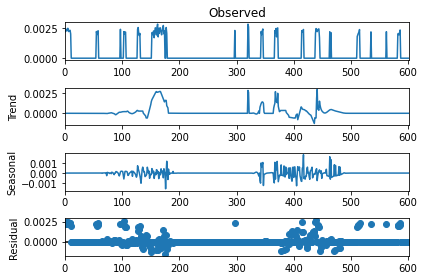

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=8, robust=True)
res = stl.fit()
fig = res.plot()

In [38]:
def rolling_predictions(train, test, order, modelType='ARIMA'):
  # put training points in a list
  history = [x for x in train]
  # for storing predictions
  predictions = list()

  # walk-forward validation
  for t in range(len(test)):
    # fit new model each iteration based on all past data points
    # get the next datapoint and add it to predictions
    if (modelType == 'SARIMAX'):
      model = SARIMAX(history, order=order).fit()
    
    else:
      model = ARIMA(history, order=order).fit()
    
    output = model.forecast()[0]
    predictions.append(output)
    history.append(test[t])

  rmse = sqrt(mean_squared_error(test, predictions))
  return (predictions, rmse)

In [67]:
predictions_arima, rmse_arima = rolling_predictions(train, test, order=(3, 1, 0))

In [69]:
print (((rmse_arima - baseline_rmse) / baseline_rmse) * 100)
print (rmse_arima)

-0.06871484705964256
0.0006308700489740203


In [41]:
def plot_preds(test, predictions):
  plt.title('Hourly lighting cost predictions')
  plt.xlabel('Timestep')
  plt.ylabel('Cost in Dollars')
  plt.plot(test)
  plt.plot(predictions, color='red')
  plt.show()

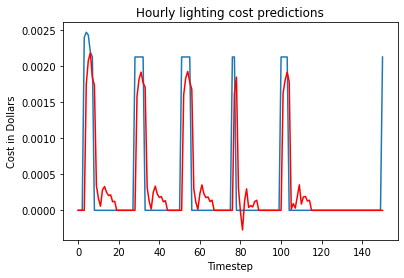

5.643358e-04


In [ ]:
plot_preds(test, predictions_arima)
print ("{:e}".format(rmse_arima))

In [ ]:
auto_arima_model = auto_arima(train)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  603
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3690.334
Date:                Tue, 12 Oct 2021   AIC                          -7372.668
Time:                        03:26:33   BIC                          -7355.060
Sample:                             0   HQIC                         -7365.815
                                - 603                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.447e-05   7.71e-05      0.966      0.334   -7.66e-05       0.000
ar.L1          0.6703      0.053     12.627      0.000       0.566       0.774
ar.L2          0.0887      0.028      3.195      0.001       0.034       0.143
sigma2      2.799e-07   1.91e-08     14.684      0.000    2.43e-07    3.17e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2449.16
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.15
Prob(H) (two-sided):                  0.54   Kurtosis:                        12.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predictions_auto_arima, rmse_auto_arima = rolling_predictions(train, test, order=(2, 0, 0), modelType='SARIMAX')

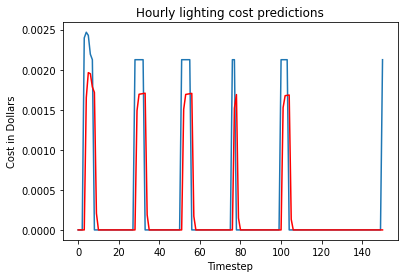

5.579174e-04


In [ ]:
plot_preds(test, predictions_auto_arima)
print ("{:e}".format(rmse_auto_arima))

In [47]:
# evaluate combinations of p, d and q values for an ARIMA model
def grid_search(train, test, p_values, d, q, modelType='ARIMA'):
  best_score, best_cfg = float("inf"), None

  for p in p_values:
    order = (p,d,q)

    try:
      preds, rmse = rolling_predictions(train, test, order=order, modelType=modelType)
      plot_preds(test, preds)

      if rmse < best_score:
        best_score, best_cfg = rmse, order

      print('ARIMA%s RMSE=%.3f' % (order, rmse))

    except:
      continue

  print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
  return best_cfg, best_score

In [ ]:
import warnings

# evaluate parameters
p_values = range(0, 3)
warnings.filterwarnings("ignore")
order, score = grid_search(train, test, p_values, 1, 0)

In [44]:
train, test = split_train_test(bulb_data_daily_aggd[['timestamp', 'cost_per_bulb']], 0.8)
print (len(train), len(test))

42 11


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


0.0190324986058131


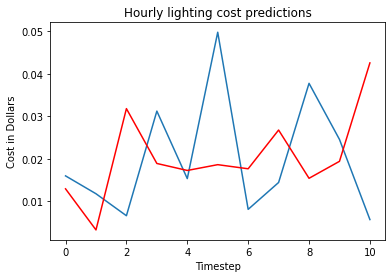

In [46]:
predictions_arima, rmse_arima = rolling_predictions(train, test, order=(5, 1, 0))
print (rmse_arima)
plot_preds(test, predictions_arima)

- ARIMA (10, 1, 0) RMSE = 5.643358e-04
- SARIMAX (2, 0, 0) RMSE = 5.579174e-04

Save model for later use

In [ ]:
train, test = split_train_test(bulb_data[['timestamp', 'cost_per_bulb']], 1.0)
print (len(train), len(test))
model = ARIMA(train, order=(1, 1, 0))
model_fit = model.fit(train)

754 0


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
import pickle
pickle.dump(model_fit, open('smart_bulb_arima(1,1,0).pkl', 'wb'))

In [ ]:
loaded = pickle.load(open('smart_bulb_arima(1,1,0).pkl', 'rb'))

In [ ]:
loaded.forecast(steps=7).tolist()

[0.0021296434324235315,
 0.0021296535802011055,
 0.002129653602378103,
 0.0021296536024265687,
 0.0021296536024266745,
 0.002129653602426675,
 0.002129653602426675]